In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skimage.data
from skimage import data, color, feature, transform
from sklearn.datasets import fetch_lfw_people
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

## Отображение направлений изменения интенсивности цвета

Text(0.5, 1.0, 'Визуализация HOG признаков')

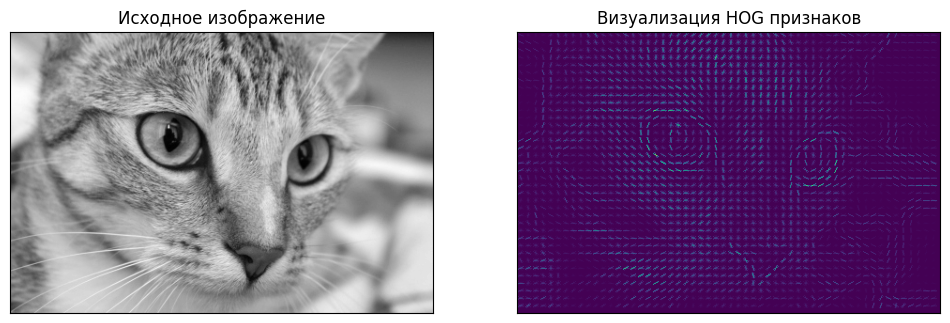

In [ ]:
image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Исходное изображение')
ax[1].imshow(hog_vis)
ax[1].set_title('Визуализация HOG признаков')

## Обнаружение лица + скользящее окно

In [ ]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [ ]:
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']

images = []

for name in imgs_to_use:
    img = getattr(data, name)()
    if img.ndim == 3:
        img = color.rgb2gray(img)
    images.append(img)

In [ ]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
  extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
  extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
  patches = extractor.transform(img[np.newaxis])

  if scale != 1:
    patches = np.array([transform.resize(patch, patch_size) for patch in patches])

  return patches


negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

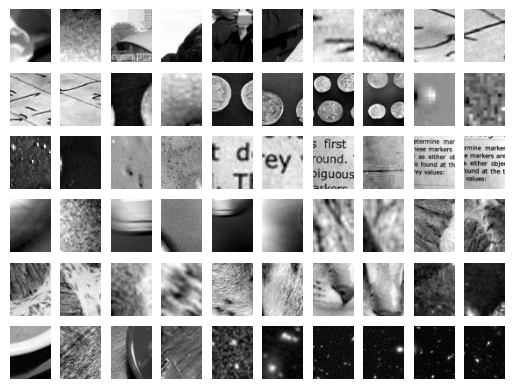

In [ ]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
  axi.imshow(negative_patches[500*i], cmap='gray')
  axi.axis('off')

In [ ]:
X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
X_train.shape

(43233, 1215)

In [ ]:
cross_val_score(GaussianNB(), X_train, y_train)

array([0.95663236, 0.972476  , 0.97363247, 0.97640527, 0.97536433])

In [ ]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

0.9887817015824171
{'C': 2.0}


In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0)

(-0.5, 129.5, 159.5, -0.5)

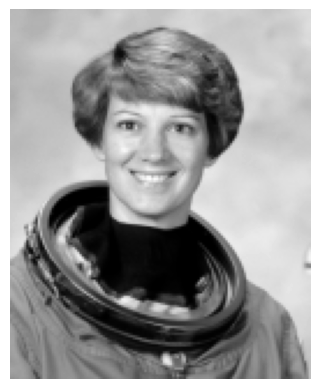

In [ ]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 50:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
  Ni, Nj = (int(scale * s) for s in patch_size)
  for i in range(0, img.shape[0] - Ni, istep):
    for j in range(0, img.shape[1] - Ni, jstep):
      patch = img[i:i + Ni, j:j + Nj]
      if scale != 1:
        patch = transform.resize(patch, patch_size)
      yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1666, 1215)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

46.0

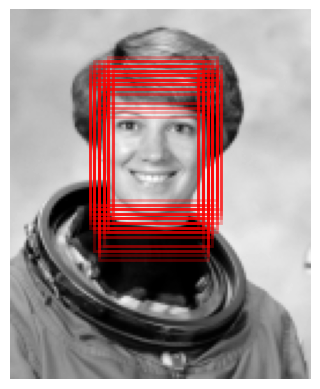

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels==1]:
  ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw = 2, facecolor='none'))

# SSD

In [1]:
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [3]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

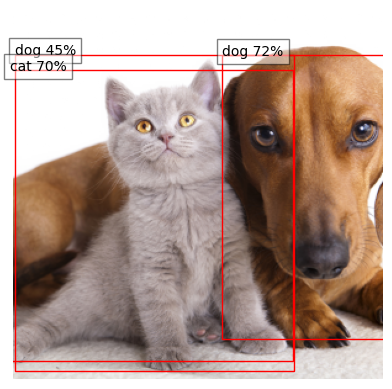

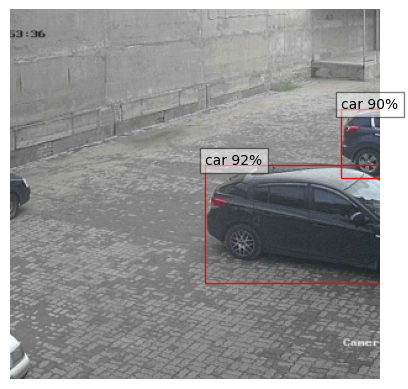

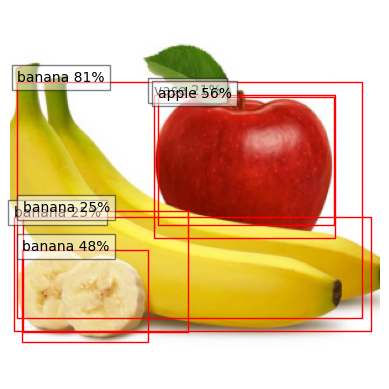

In [7]:
images_path = [
    '/content/images/Cats_Dogs_Kittens_499344.jpg',
    '/content/images/image.png',
    '/content/images/platano-manzana.jpg'
]

inputs = [utils.prepare_input(uri) for uri in images_path]
tensor = utils.prepare_tensor(inputs)

with torch.no_grad():
    detections_batch = ssd_model(tensor)

results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]

classes_to_labels = utils.get_coco_object_dictionary()

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
plt.show()

## Операция заняла 11 секунд, в среднем 3-4 секунды на изображение